## Import libs

In [1]:
import tensorflow as tf
from pathlib import Path
from util.dataset import Dataset as madras_Dataset
from util import read_data as rd
from tensorflow.keras import layers
from zhang.models import FairLogisticRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from util import metrics
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)

## Load data

In [3]:
data_name = 'adult'

data_info = rd.return_data_info(data_name)
npzfile = rd.return_npz(data_name)

data = madras_Dataset(npzfile=npzfile, name=data_name, a0_name=data_info['a0_name'], a1_name=data_info['a1_name'], 
                use_a=data_info['use_a'], seed=data_info['seed'], batch_size=batch_size)

data_shapes = list(data.get_shapes())
#print(data_shapes)

xdim = data_shapes[0][1]
ydim = data_shapes[1][1]
adim = data_shapes[2][1]
zdim = 8

In [4]:
train_data = Dataset.from_tensor_slices((data.x_train, data.y_train, data.a_train))
train_data = train_data.batch(batch_size)
train_data

<BatchDataset shapes: ((None, 113), (None, 1), (None, 1)), types: (tf.float64, tf.float32, tf.float32)>

In [5]:
valid_data = Dataset.from_tensor_slices((data.x_valid, data.y_valid, data.a_valid))
valid_data = valid_data.batch(batch_size)

In [6]:
data.y_valid.shape

(6016, 1)

## Train loop

In [7]:
import math

'''def gen_projection_matrix(v):
    return tf.matmul(v, v) / tf.multiply(v, v)

def calc_projection(x, p):
  return tf.multiply(P, tf.transpose(x))

def projection(v, x):
    if v==0:
        return 0
    else:
        p = gen_projection_matrix(v)
        P = calc_projection(x, p)
        return P '''

def projection(v, x):
    if v==0:
        return 0
    else:
        return 1 #idk what to return yet

def train(model, X, Y, A, optimizer, alpha=1, learning_rate=0.001):
    clas_vars = [model.clas.W] #+ model.b + model.c
    adv_vars = [model.adv.U, model.b, model.adv.c]
    #adv_vars = [model.adv.U, model.b, model.c]
    variables = [model.clas.W, model.b]
    #variables = [model.clas.W, model.adv.U]
    #variables = [model.clas.W]

    with tf.GradientTape(persistent=True) as clas_tape, tf.GradientTape() as adv_tape:
        
        #adv_tape.watch(adv_vars)
        #clas_tape.watch(variables)

        model(X, Y, A) #to compute the foward
        adv_loss = model.adv_loss #current adversarial loss
        clas_loss = model.clas_loss #current classifier loss
        model_loss = model.model_loss

        #print(adv_loss)
        #print(clas_loss)

    if math.isnan(adv_loss) or math.isnan(clas_loss):
        print('any loss is NaN')
        return True
    #print(model.adv.U)
    #print(model.b)
    #print(model.adv.c)
    dULa = adv_tape.gradient(adv_loss, adv_vars) #adv_grads
    #print('dULa ', dULa)
    optimizer.apply_gradients(zip(dULa, adv_vars))

    '''dWLp = clas_tape.gradient(clas_loss, variables)
    optimizer.apply_gradients(zip(dWLp, variables))'''
    dWLp = clas_tape.gradient(clas_loss, variables) #regular grads for classifier
    #print('dWLp ', dWLp)   
    dWLa = clas_tape.gradient(adv_loss, variables) #grads for W with the adversarial loss
    #print('dWLa ', dWLa)
    proj_dWLa_dWLp = projection(dWLa, dWLp) #prevents the classifier from moving in a direction that helps the adversary decrease its loss
    #print('proj ', proj_dWLa_dWLp)
    #print('alpha ', alpha)
    #max_adv_loss = tf.multiply(alpha,dWLa) #terms that attemps to increase adv loss
    max_adv_loss = [] #terms that attemps to increase adv loss
    for i in range(len(dWLa)):
        max_adv_loss.append(tf.multiply(alpha, dWLa[i]))
    #print('max ', max_adv_loss)
    
    proj_minus_max_adv_loss = [] 
    for i in range(len(max_adv_loss)):
        proj_minus_max_adv_loss.append(tf.multiply(proj_dWLa_dWLp, max_adv_loss[i]))
    #print('max ', max_adv_loss)
    #clas_grads = tf.subtract(dWLp, tf.subtract(proj_dWLa_dWLp, max_adv_loss))
    #clas_grads = tf.subtract(dWLp, dWLa)
    clas_grads = []
    for i in range(len(dWLa)):
        clas_grads.append(tf.subtract(dWLp[i],  proj_minus_max_adv_loss[i]))
    #print('clas grads', clas_grads)
    optimizer.apply_gradients(zip(clas_grads, variables))

    return False

In [8]:
from math import sqrt

def train_loop(model, train_dataset, epochs, optmizer):
    
    print("> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc")

    losses = {'clas':[], 'adv':[]}
    accs = {'clas':[], 'adv':[]}

    dps = []
    dis = []
    deopps = []

    batch = 1
    
    for epoch in range(epochs):
        clas_losses = []
        adv_losses = []
        clas_accs = []
        adv_accs = []
        Y_hat = None
        A_hat = None
        count = 1

        alpha=sqrt(epoch+1)
        lr=1/(epoch+1)
        
        for X, Y, A in train_dataset:
            #print('batch ', batch)
            batch+=1
            
            r = train(model, X, Y, A, optmizer, alpha, lr)
            if r:
                break

            if count == 1:
                Y_hat = model.Y_hat
                A_hat = model.A_hat
                count += 1
            else:
                Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
                A_hat = tf.concat([A_hat, model.A_hat], 0)

        clas_loss = model.clas_loss
        adv_loss = model.adv_loss
        clas_acc = metrics.accuracy(data.y_train, tf.math.round(Y_hat))
        adv_acc = metrics.accuracy(data.a_train, tf.math.round(A_hat))
    
        print("> {} | {} | {} | {} | {}".format(
            epoch+1, 
            clas_loss,
            adv_loss, 
            clas_acc,
            adv_acc))
        #print(model.clas.W)

    #return losses, accs, dps, dis, deopps

## Validation

In [9]:
def validation(model, valid_data):
    '''
    clas_acc = []
    adv_acc = []
    clas_loss = []
    adv_loss = []
    dp = []
    di = []
    deopp = []
    tp, tn, fp, fn = 0, 0, 0, 0
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    m = [metrics.TP, metrics.TN, metrics.FP, metrics.FN]'''
    Y_hat = None
    A_hat = None
    count = 1
    for X, Y, A in valid_data:
        
        model(X, Y, A)
        '''if count==1:
            print(model.clas.W)
            print(model.b)
            x_w = tf.matmul(tf.dtypes.cast(X, tf.float32), tf.transpose(model.clas.W))
            print(x_w)
            pred = tf.math.sigmoid(
                        tf.add(x_w, model.b))
            print(pred)
            count+=1'''
        if count == 1:
            Y_hat = model.Y_hat
            A_hat = model.A_hat
            count += 1
        else:
            Y_hat = tf.concat([Y_hat, model.Y_hat], 0)
            A_hat = tf.concat([A_hat, model.A_hat], 0)
    
    return Y_hat, A_hat

        
    '''clas_loss.append(model.clas_loss)
        adv_loss.append(model.adv_loss)
        
        clas_acc.append(metrics.accuracy(Y, tf.math.round(model.Y_hat)))
        adv_acc.append(metrics.accuracy(A, tf.math.round(model.A_hat)))

        dp.append(metrics.DP(tf.math.round(model.Y_hat).numpy(), A))
        di.append(metrics.DI(Y.numpy(), tf.math.round(model.Y_hat).numpy(), A.numpy()))
        deopp.append(metrics.DI_soft(Y.numpy(), tf.math.round(model.Y_hat).numpy(), A.numpy()))

        tp += metrics.TP(Y.numpy(), tf.math.round(model.Y_hat).numpy())
        tn += metrics.TN(Y.numpy(), tf.math.round(model.Y_hat).numpy())
        fp += metrics.FP(Y.numpy(), tf.math.round(model.Y_hat).numpy())
        fn += metrics.FN(Y.numpy(), tf.math.round(model.Y_hat).numpy())
        for i in range(len(metrics_a0)):
            metrics_a0[i] += metrics.subgroup(m[i], 1 - A.numpy(), Y.numpy(), tf.math.round(model.Y_hat).numpy())
            metrics_a1[i] += metrics.subgroup(m[i], A.numpy(), Y.numpy(), tf.math.round(model.Y_hat).numpy())
    
    print("> Class Loss | Adv Loss | Class Acc | Adv Acc")
    print("> {} | {} | {} | {}".format(
            tf.math.reduce_mean(clas_loss),
            tf.math.reduce_mean(adv_loss),
            tf.math.reduce_mean(clas_acc),
            tf.math.reduce_mean(adv_acc)))

    return clas_acc, clas_loss, adv_acc, adv_loss, dp, di, deopp, tp, tn, fp, fn, metrics_a0, metrics_a1'''

In [10]:
def compute_metrics(Y, Y_hat, A, A_hat):
    Y_hat = tf.math.round(Y_hat)
    A_hat = tf.math.round(A_hat)
    
    clas_acc = metrics.accuracy(Y, Y_hat)
    adv_acc = metrics.accuracy(A, A_hat)

    print("> Class Acc | Adv Acc")
    print("> {} | {}".format(clas_acc, adv_acc))

    dp = metrics.DP(Y_hat.numpy(), A)
    di = metrics.DI(Y, Y_hat.numpy(), A)
    deopp = metrics.DI_soft(Y, Y_hat.numpy(), A)

    print("> DP | DI | DEOPP")
    print("> {} | {} | {}".format(dp, di, deopp))

    tp = metrics.TP(Y, Y_hat.numpy())
    tn = metrics.TN(Y, Y_hat.numpy())
    fp = metrics.FP(Y, Y_hat.numpy())
    fn = metrics.FN(Y, Y_hat.numpy())

    print('> Confusion Matrix \n' +
                'TN: {} | FP: {} \n'.format(tn, fp) +
                'FN: {} | TP: {}'.format(fn, tp))

    m = [metrics.TN, metrics.FP, metrics.FN, metrics.TP]
    metrics_a0 = [0, 0, 0, 0]
    metrics_a1 = [0, 0, 0, 0]
    for i in range(len(metrics_a0)):
        metrics_a0[i] = metrics.subgroup(m[i], 1 - A, Y, Y_hat.numpy())
        metrics_a1[i] = metrics.subgroup(m[i], A, Y, Y_hat.numpy())

    print('> Confusion Matrix for A = 0 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a0[0], metrics_a0[1]) +
            'FN: {} | TP: {}'.format(metrics_a0[2], metrics_a0[3]))

    print('> Confusion Matrix for A = 1 \n' +
            'TN: {} | FP: {} \n'.format(metrics_a1[0], metrics_a1[1]) +
            'FN: {} | TP: {}'.format(metrics_a1[2], metrics_a1[3]))

    return clas_acc, dp, di, deopp

## Testing if models are being trained

### For DP

In [11]:
fairdef='DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.7097282409667969 | 0.811843752861023 | 0.3303630636604774 | 0.37031664456233426


In [12]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7189162234042553 | 0.6072140957446808
> DP | DI | DEOPP
> 0.0005739033222198486 | 0.024927504360675812 | 0.00044764578342437744
> Confusion Matrix 
TN: 3823.0 | FP: 648.0 
FN: 1043.0 | TP: 502.0
> Confusion Matrix for A = 0 
TN: 2383.0 | FP: 343.0 
FN: 896.0 | TP: 431.0
> Confusion Matrix for A = 1 
TN: 1440.0 | FP: 305.0 
FN: 147.0 | TP: 71.0


### For EqOdds

In [13]:
fairdef='EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.6812757253646851 | 0.8058940172195435 | 0.7541860079575597 | 0.6658239389920424


In [14]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.746343085106383 | 0.6672207446808511
> DP | DI | DEOPP
> 0.02280821092426777 | 0.018291082233190536 | 0.015365418046712875
> Confusion Matrix 
TN: 4350.0 | FP: 121.0 
FN: 1405.0 | TP: 140.0
> Confusion Matrix for A = 0 
TN: 2646.0 | FP: 80.0 
FN: 1201.0 | TP: 126.0
> Confusion Matrix for A = 1 
TN: 1704.0 | FP: 41.0 
FN: 204.0 | TP: 14.0


### For EqOpp

In [18]:
fairdef='EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
ret = train_loop(model, train_data, 1, opt)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.9932544231414795 | 0.7177422046661377 | 0.22679045092838201 | 0.6711704244031831


In [19]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Class Acc | Adv Acc
> 0.23105053191489366 | 0.6737034574468085
> DP | DI | DEOPP
> 0.03830158710479736 | 0.0066390931606292725 | 0.0057866573333740234
> Confusion Matrix 
TN: 184.0 | FP: 4287.0 
FN: 339.0 | TP: 1206.0
> Confusion Matrix for A = 0 
TN: 114.0 | FP: 2612.0 
FN: 289.0 | TP: 1038.0
> Confusion Matrix for A = 1 
TN: 70.0 | FP: 1675.0 
FN: 50.0 | TP: 168.0


## Models

In [20]:
#For DemPar
fairdef = 'DemPar'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4dp = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc


KeyboardInterrupt: 

In [37]:
#For EqOdds
fairdef = 'EqOdds'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4eqodds = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 1.0587365627288818 | 0.724186897277832 | 0.28125 | 0.671875
> 2 | 1.050900936126709 | 0.7206194996833801 | 0.28125 | 0.5625
> 3 | 0.9137789607048035 | 0.7570473551750183 | 0.65625 | 0.34375
> 4 | 0.7008612751960754 | 0.8539385795593262 | 0.65625 | 0.34375
> 5 | 0.6950896382331848 | 0.8804723024368286 | 0.671875 | 0.328125
> 6 | 0.6941457986831665 | 0.9014761447906494 | 0.671875 | 0.328125
> 7 | 0.6938830018043518 | 0.9192107319831848 | 0.671875 | 0.328125
> 8 | 0.6937823295593262 | 0.9339293837547302 | 0.671875 | 0.328125
> 9 | 0.6937150359153748 | 0.945887565612793 | 0.671875 | 0.328125
> 10 | 0.6936440467834473 | 0.9554414749145508 | 0.671875 | 0.328125
Validation
> Class Acc | Adv Acc
> 0.742686170212766 | 0.32646276595744683
> DP | DI | DEOPP
> 1.5962752513587475e-05 | 8.030491881072521e-05 | 0.0
> Confusion Matrix 
TN: 4468.0 | FP: 3.0 
FN: 1545.0 | TP: 0.0
> Confusion Matrix for A = 0 
TN: 2724.0 | FP: 2.0 
FN: 1327.0 | 

In [38]:
#For EqOpp
fairdef = 'EqOpp'
model = FairLogisticRegression(xdim, batch_size, fairdef)
train_loop(model, train_data, epochs, opt)
print('Validation')
Y_hat, A_hat = validation(model, valid_data)
ret4eqoopp = compute_metrics(data.y_valid, Y_hat, data.a_valid, A_hat)

> Epoch | Class Loss | Adv Loss | Class Acc | Adv Acc
> 1 | 0.7023729681968689 | 0.8006534576416016 | 0.734375 | 0.671875
> 2 | 0.6988224983215332 | 0.7991091012954712 | 0.734375 | 0.421875
> 3 | 0.6985467076301575 | 0.8100436925888062 | 0.734375 | 0.421875
> 4 | 0.6984484195709229 | 0.8253659605979919 | 0.734375 | 0.421875
> 5 | 0.6984027028083801 | 0.8423832058906555 | 0.734375 | 0.421875
> 6 | 0.6983810067176819 | 0.8591903448104858 | 0.734375 | 0.421875
> 7 | 0.6983733773231506 | 0.8745080828666687 | 0.734375 | 0.421875
> 8 | 0.6983771920204163 | 0.8876941204071045 | 0.734375 | 0.421875
> 9 | 0.6983941793441772 | 0.8986072540283203 | 0.734375 | 0.421875
> 10 | 0.6984291672706604 | 0.9074089527130127 | 0.734375 | 0.421875
Validation
> Class Acc | Adv Acc
> 0.7726063829787234 | 0.3986037234042553
> DP | DI | DEOPP
> 0.06214462220668793 | 0.015856679528951645 | 0.011872336268424988
> Confusion Matrix 
TN: 4170.0 | FP: 301.0 
FN: 1067.0 | TP: 478.0
> Confusion Matrix for A = 0 
TN: 253

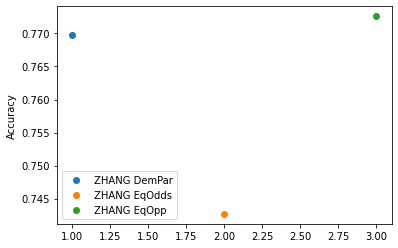

In [39]:
#x=[1,2,3]
#y = [tf.math.reduce_mean(ret4dp[0]),tf.math.reduce_mean(ret4eqodds[0]),tf.math.reduce_mean(ret4eqodds[0])]
y=[2,4,6]
#plt.scatter()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points'''

# plotting the line 2 points 
#plt.scatter(x, y)

plt.scatter(1, ret4dp[0], label = "ZHANG DemPar")

plt.scatter(2, ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(3, ret4eqoopp[0], label = "ZHANG EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()
plt.show()

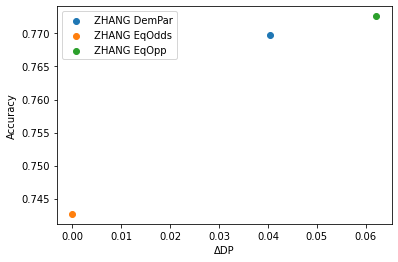

In [40]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''
#axes = plt.gca()
#axes.set_xlim([0.0643,0.0645])
plt.scatter(ret4dp[1], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqoopp[1], ret4eqoopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

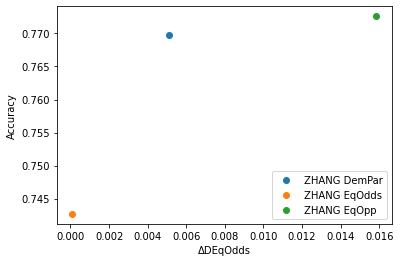

In [41]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[2], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqoopp[2], ret4eqoopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

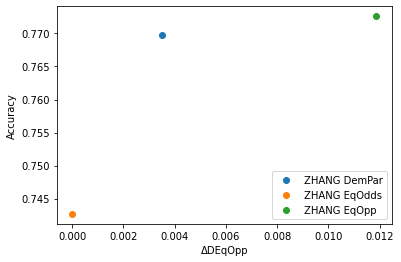

In [42]:
plt.plot()
plt.ylabel('Accuracy')

'''# plotting the line 1 points 
plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points'''

plt.scatter(ret4dp[3], ret4dp[0], label = "ZHANG DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "ZHANG EqOdds")

plt.scatter(ret4eqoopp[3], ret4eqoopp[0], label = "ZHANG EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()